&copy;  C. Lázaro, Universidad Politécnica de Valencia, 2015

# Form finding of planar flexible rods (3)

We will implement the force density method and apply it with active bent members

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## 1 Classical 2D Force density equations

### 1.1 Connectivity matrix

Following [Schek, 1973](http://www.sciencedirect.com/science/article/pii/0045782574900450), the connectivity matrix $[\mathbf{C}_l \;\mathbf{C}_f]$ has $\mathsf{M}$ rows and $\mathsf{N}$ columns, being $\mathsf{N}$ the number of nodes and $\mathsf{M}$ the number of members in the structure. $\mathbf{C}_f$ gathers the columns which correspond to the restrained nodes. The definition of the elements is as follows:
Given a member $m$ with end nodes $j, k$
$$C[m, i] = 
\begin{Bmatrix}
+1 \;\text{for}\; i = j \\
-1 \;\text{for}\; i = k \\
0 \;\text{otherwise}
\end{Bmatrix}$$

In [54]:
NN = 6
NF = 5
MM = 5
C = np.zeros((MM, NN))

In [58]:
C[0, 0] = 1; C[0, 1] = -1    # element 1
C[1, 0] = 1; C[1, 2] = -1    # element 2
C[2, 0] = 1; C[2, 3] = -1    # element 3
C[3, 0] = 1; C[3, 4] = -1    # element 4
C[4, 0] = 1; C[4, 5] = -1    # element 4

In [59]:
CL = C[:, 0:(NN - NF)]
CF = C[:, (NN - NF):]

In [60]:
print(C)

[[ 1. -1.  0.  0.  0.  0.]
 [ 1.  0. -1.  0.  0.  0.]
 [ 1.  0.  0. -1.  0.  0.]
 [ 1.  0.  0.  0. -1.  0.]
 [ 1.  0.  0.  0.  0. -1.]]


We consider now the equilibrium of the node $i$ joining nodes $j, k, l$ through members $m, n, r$, respectively
$$ N_m \lambda_m + N_n \lambda_n + N_r \lambda_r + \phi_i = \mathbf{0}$$
where $N_m$ are the axial forces of member $m$ etc., $\lambda_m = (\gamma_j - \gamma_i)/d_m$, etc., are the unit vectors pointing from node $i$ outwards, and $\phi_i$ is the external force vector acting on node $i$. Therefore we may write
$$q_m (\gamma_i - \gamma_j) + q_n (\gamma_i - \gamma_k) + q_r  (\gamma_i - \gamma_l) = \phi_i$$
where $q_m = N_m / d_m$ are the force densities, or we can arrange the equation in matrix form as
$$\begin{bmatrix}
1 & 1 & 1 \\
\end{bmatrix}
\begin{bmatrix}
q_m & 0 & 0 \\
0 & q_n & 0 \\
0 & 0 & q_r
\end{bmatrix}
\begin{bmatrix}
1 & -1 & 0 & 0\\
1 & 0 & -1 & 0 \\
1 & 0 & 0 & -1
\end{bmatrix}
\begin{Bmatrix}
\gamma_i \\
\gamma_j \\
\gamma_k \\
\gamma_l
\end{Bmatrix} = \phi_i
$$
The system of equations for the complete structure is as follows:
$$\begin{bmatrix}
\mathbf{C}^{\mathsf{T}}_l \\
\mathbf{C}^{\mathsf{T}}_f
\end{bmatrix}
\mathbf{Q}\;
\begin{bmatrix}
\mathbf{C}_l & \mathbf{C}_f
\end{bmatrix}
\begin{Bmatrix}
\mathbf{\gamma}_l \\
\mathbf{\gamma}_f
\end{Bmatrix} =
\begin{Bmatrix}
\mathbf{\phi}_l\\
\mathbf{\phi}_f
\end{Bmatrix}
$$

### 1.2 Force density matrix

In [86]:
q = [5., -1.5, 5., -7.5, 2.5]    # force densities in kN/m corresponding to every element
qQ = np.diagflat(q)

### 1.3 Restrained nodes

We are using complex numbers for working in the 2D plane

In [87]:
gammaF = np.array([-5. + -5.*1j, 3. + -5.*1j, 5. + 3.*1j, -1. + 6.*1j, -5. + 5.*1j ])

### 1.4 External forces

In [88]:
fL = np.array([0. + (-5.)*1j])

### 1.5 Solving for the free nodes

$$\mathbf{D}_l = \mathbf{C}_l^{\mathsf{T}} \,\mathbf{Q}\,\mathbf{C}_l$$
$$\mathbf{D}_f = \mathbf{C}_l^{\mathsf{T}} \,\mathbf{Q}\,\mathbf{C}_f $$
$$\mathbf{\gamma}_l = \mathbf{D}_l^{-1} \bigl( \mathbf{\phi}_l - \mathbf{D}_f \,\mathbf{\gamma}_f \bigr)$$

In [89]:
gammaL = np.zeros(NN - NF)
DL = np.zeros((NN - NF, NN - NF))
DF = np.zeros((NN - NF, NF))

DL = np.dot(np.transpose(CL), np.dot(qQ, CL))
DF = np.dot(np.transpose(CL), np.dot(qQ, CF))

gammaL = np.linalg.solve(DL, fL - np.dot(DF, gammaF))
gammaL

array([-2.71428571-11.42857143j])

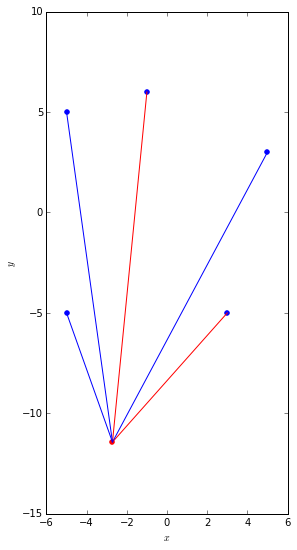

In [92]:
fig = plt.figure(figsize=(9,9))

ax = fig.gca(aspect='equal')
ax.scatter(gammaF.real, gammaF.imag, color='b')
ax.scatter(gammaL.real, gammaL.imag, color='r')
for i in range(MM):
    if q[i] > 0.:
        col = 'b'
    else:
        col = 'r'
    ax.plot([gammaL.real[0], gammaF.real[i]], [gammaL.imag[0], gammaF.imag[i]], color = col)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

## 2 Force density for active bending members

The equilibrium equation for node $J$ with active bending members $IJ$ and $JK$ and tension (compression) member $JL$ is
$$N_{IJ} (\mathbf{x}_I - \mathbf{x}_J)/d_{IJ} + V_{IJ} \mathbf{J}(\mathbf{x}_I - \mathbf{x}_J)/d_{IJ} +
N_{JK} (\mathbf{x}_K - \mathbf{x}_J)/d_{KJ} + V_{JK} \mathbf{J}(\mathbf{x}_K - \mathbf{x}_J)/d_{IJ} +
N_{JL} (\mathbf{x}_L - \mathbf{x}_J)/d_{JL} + \mathbf{f}_J = \mathbf{0}$$
where
$$ \mathbf{J} =
\begin{bmatrix}
0 & -1 \\
1 & \;\;0
\end{bmatrix}$$
Rearranging the equilibrium equation,
$$n_{IJ} (\mathbf{x}_J - \mathbf{x}_I) + v_{IJ} \mathbf{J}(\mathbf{x}_J - \mathbf{x}_I) +
n_{JK} (\mathbf{x}_J - \mathbf{x}_K) + v_{JK} \mathbf{J}(\mathbf{x}_J - \mathbf{x}_K) +
n_{JL} (\mathbf{x}_J - \mathbf{x}_L) = \mathbf{f}_J$$

Defining
$$\mathbf{q}_{IJ} = \frac{N_{IJ}}{d_{IJ}}\mathbf{1} + \frac{V_{IJ}}{d_{IJ}}\mathbf{J} =
\begin{bmatrix}
n_{IJ} & -v_{IJ} \\
v_{IJ} & \;\;n_{IJ}
\end{bmatrix}$$
we can rearrange the equilibrium equation in the following way
$$\begin{bmatrix}
\mathbf{1} & \mathbf{1} & \mathbf{1}
\end{bmatrix}
\begin{bmatrix}
\mathbf{q}_{IJ} & \mathbf{0} & \mathbf{0} \\
\mathbf{0} & \mathbf{q}_{JK} & \mathbf{0} \\
\mathbf{0} & \mathbf{0} & \mathbf{q}_{KL}
\end{bmatrix}
\begin{bmatrix}
-\mathbf{1} & \mathbf{1} & \mathbf{0} & \mathbf{0} \\
\mathbf{0} & \mathbf{1} & -\mathbf{1} & \mathbf{0} \\
\mathbf{0} & \mathbf{1} & \mathbf{0} & -\mathbf{1}
\end{bmatrix}
\begin{bmatrix}
\mathbf{x}_I \\
\mathbf{x}_J \\
\mathbf{x}_K \\
\mathbf{x}_L
\end{bmatrix} = \mathbf{f}_J
$$
Therefore, the system of equations for the complete structure has the same form as in the original case. Only the force density matrix has the new structure indicated above, where tension/compression force densities are complemented by shear densities in the appropriate positions.

### 2.1 An elegant alternate way of expressing the equations

In 2D we may choose to express the product $\mathbf{J} (\mathbf{x}_J - \mathbf{x}_I)$ using complex numbers as
$$\exp{(i \frac{\pi}{2})}(\gamma_J - \gamma_I) = i \,(\gamma_J - \gamma_I)$$
Then we define the _complex force density_ as $q_{IJ} = n_{IJ} + i \,v_{IJ}$, and we may rearrange the former expression in the following way
$$\begin{bmatrix}
1 & 1 & 1
\end{bmatrix}
\begin{bmatrix}
q_{IJ} & 0 & 0 \\
0 & q_{JK} & 0 \\
0 & 0 & q_{KL}
\end{bmatrix}
\begin{bmatrix}
-1 & 1 & 0 & 0 \\
0 & 1 & -1 & 0 \\
0 & 1 & 0 & -1
\end{bmatrix}
\begin{bmatrix}
\gamma_I \\
\gamma_J \\
\gamma_K \\
\gamma_L
\end{bmatrix} = \phi_J
$$

In [165]:
NN = 6
NF = 4
MM = 5
C = np.zeros((MM, NN))

In [166]:
C[0, 0] = 1; C[0, 2] = -1    # element 1
C[1, 0] = 1; C[1, 1] = -1    # element 2
C[2, 1] = 1; C[2, 5] = -1    # element 3
C[3, 0] = 1; C[3, 3] = -1    # element 4
C[4, 1] = 1; C[4, 4] = -1    # element 5

In [167]:
CL = C[:, 0:(NN - NF)]
CF = C[:, (NN - NF):]

In [168]:
print(C)

[[ 1.  0. -1.  0.  0.  0.]
 [ 1. -1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0. -1.]
 [ 1.  0.  0. -1.  0.  0.]
 [ 0.  1.  0.  0. -1.  0.]]


In [169]:
gammaF = np.array([-5. + 0.*1j, 0. + 2.5*1j, 0 - 2.5*1j, 5. + 0.*1j])

In [364]:
q = [-5. + 1.35*1j, -5. + -5.*1j, -5. + 1.35*1j, 0., 0.]    # force densities in kN/m corresponding to every element
qQ = np.diagflat(q)
print(qQ)

[[-5.+1.35j  0.+0.j    0.+0.j    0.+0.j    0.+0.j  ]
 [ 0.+0.j   -5.-5.j    0.+0.j    0.+0.j    0.+0.j  ]
 [ 0.+0.j    0.+0.j   -5.+1.35j  0.+0.j    0.+0.j  ]
 [ 0.+0.j    0.+0.j    0.+0.j    0.+0.j    0.+0.j  ]
 [ 0.+0.j    0.+0.j    0.+0.j    0.+0.j    0.+0.j  ]]


In [365]:
fL = np.array([0. + (0.)*1j])

In [366]:
gammaL = np.zeros(NN - NF)
DL = np.zeros((NN - NF, NN - NF))
DF = np.zeros((NN - NF, NF))

DL = np.dot(np.transpose(CL), np.dot(qQ, CL))
DF = np.dot(np.transpose(CL), np.dot(qQ, CF))

gammaL = np.linalg.solve(DL, fL - np.dot(DF, gammaF))
print(gammaL)

[-1.0559998+1.05895988j  1.0559998-1.05895988j]


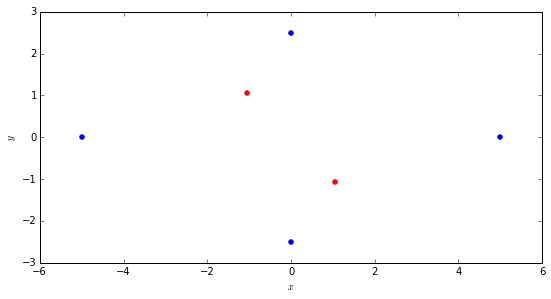

In [367]:
fig = plt.figure(figsize=(9,9))

ax = fig.gca(aspect='equal')
ax.scatter(gammaF.real, gammaF.imag, color='b')
ax.scatter(gammaL.real, gammaL.imag, color='r')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [368]:
gamma = np.concatenate((gammaL, gammaF), axis=0)
d = np.absolute((np.dot(C, gamma)))
f = q*d
V = np.imag(f)
DM = -V*d
print(DM)

[-22.51332038  44.73063229 -22.51332038  -0.          -0.        ]
